<a href="https://colab.research.google.com/github/DRA-chaos/Quantum-Convolutional-Neural-Network/blob/main/GPU_Changing_QCNN_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 9.9MB/s 
     |████████████████████████████████| 18.0MB 171kB/s 
     |████████████████████████████████| 235kB 52.1MB/s 
     |████████████████████████████████| 215kB 54.8MB/s 
     |████████████████████████████████| 2.1MB 42.2MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 1.5MB 37.4MB/s 
     |████████████████████████████████| 194kB 31.4MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 614kB 48.0MB/s 
     |████████████████████████████████| 3.2MB 39.2MB/s 
     |████████████████████████████████| 6.3MB 27.6MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=b9c45c0519e2d1175f6cebad9fc69cffd67de95583f1751dd59bfe8dd5a0f413
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel for python-constraint: filename=python_constraint-1.4.0-p

In [2]:
# check if CUDA is available
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [4]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [6]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [7]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [8]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)


Extracting ./data1/cifar-10-python.tar.gz to ./data1


In [ ]:
len(cifar_trainset)

50000

In [9]:
from torch.utils.data import DataLoader, random_split

In [10]:
#cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)


labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx] 
cifar_trainset.data = cifar_trainset.data[idx]

cifar_trainset, valid = random_split(cifar_trainset,[150,50])

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=True)

In [11]:
@torch.no_grad()
def get_all_preds(model, test_loader):
    all_preds = torch.tensor([])
    for batch in test_loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

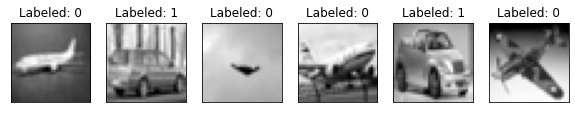

In [12]:
import numpy as np  
import matplotlib.pyplot as plt

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
  
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [13]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels = cifar_testset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_testset.targets = labels[idx] 
cifar_testset.data = cifar_testset.data[idx]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

Files already downloaded and verified


Model one of the Hybrid Quantum Neural Network

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Epoch: 1 	Training Loss: -0.522200 	Validation Loss: -0.737400
Epoch: 2 	Training Loss: -0.583133 	Validation Loss: -0.815800
Epoch: 3 	Training Loss: -0.685667 	Validation Loss: -0.864000
Epoch: 4 	Training Loss: -0.701000 	Validation Loss: -0.891200
Epoch: 5 	Training Loss: -0.723067 	Validation Loss: -0.885000
Epoch: 6 	Training Loss: -0.691200 	Validation Loss: -0.910800
Epoch: 7 	Training Loss: -0.738400 	Validation Loss: -0.962400
Epoch: 8 	Training Loss: -0.768200 	Validation Loss: -0.977800
Epoch: 9 	Training Loss: -0.760333 	Validation Loss: -0.983600
Epoch: 10 	Training Loss: -0.773733 	Validation Loss: -0.983600
Epoch: 11 	Training Loss: -0.797467 	Validation Loss: -0.990600
Epoch: 12 	Training Loss: -0.834400 	Validation Loss: -0.972200
Epoch: 13 	Training Loss: -0.827800 	Validation Loss: -0.976400
Epoch: 14 	Training Loss: -0.825667 	Validation Loss: -0.985000
Epoch: 15 	Training Loss: -0.851467 	Validation Loss: -0.990800
Epoch: 16 	Training Loss: -0.837400 	Validation L

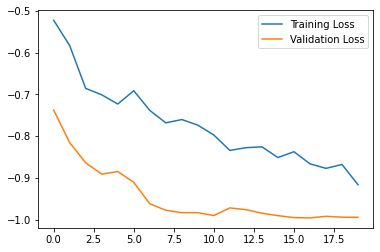

Performance on test data:
	Loss: -0.7615
	Accuracy: 80.5%


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.554800 	Validation Loss: -0.782000
Epoch: 2 	Training Loss: -0.532667 	Validation Loss: -0.831200
Epoch: 3 	Training Loss: -0.519733 	Validation Loss: -0.873400
Epoch: 4 	Training Loss: -0.599800 	Validation Loss: -0.890400
Epoch: 5 	Training Loss: -0.653867 	Validation Loss: -0.919400
Epoch: 6 	Training Loss: -0.664600 	Validation Loss: -0.931200
Epoch: 7 	Training Loss: -0.714267 	Validation Loss: -0.933600
Epoch: 8 	Training Loss: -0.715467 	Validation Loss: -0.935400
Epoch: 9 	Training Loss: -0.764133 	Validation Loss: -0.938000
Epoch: 10 	Training Loss: -0.738600 	Validation Loss: -0.934200
Epoch: 11 	Training Loss: -0.763533 	Validation Loss: -0.930000
Epoch: 12 	Training Loss: -0.763733 	Validation Loss: -0.937600
Epoch: 13 	Training Loss: -0.791733 	Validation Loss: -0.936800
Epoch: 14 	Training Loss: -0.816267 	Validation Loss: -0.936400
Epoch: 15 	Training Loss: -0.756733 	Validation Loss: -0.942000
Epoch: 16 	Training Loss: -0.793133 	Validation L

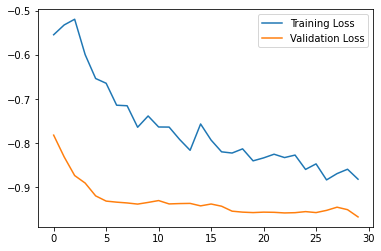

Performance on test data:
	Loss: -0.7678
	Accuracy: 80.0%


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.489933 	Validation Loss: -0.803200
Epoch: 2 	Training Loss: -0.544800 	Validation Loss: -0.861400
Epoch: 3 	Training Loss: -0.496400 	Validation Loss: -0.907600
Epoch: 4 	Training Loss: -0.477333 	Validation Loss: -0.928000
Epoch: 5 	Training Loss: -0.540467 	Validation Loss: -0.955400
Epoch: 6 	Training Loss: -0.537867 	Validation Loss: -0.964800
Epoch: 7 	Training Loss: -0.613667 	Validation Loss: -0.973600
Epoch: 8 	Training Loss: -0.679600 	Validation Loss: -0.975200
Epoch: 9 	Training Loss: -0.691333 	Validation Loss: -0.984200
Epoch: 10 	Training Loss: -0.722600 	Validation Loss: -0.992600
Epoch: 11 	Training Loss: -0.768533 	Validation Loss: -0.992200
Epoch: 12 	Training Loss: -0.754000 	Validation Loss: -0.995400
Epoch: 13 	Training Loss: -0.757133 	Validation Loss: -0.998200
Epoch: 14 	Training Loss: -0.764600 	Validation Loss: -0.998200
Epoch: 15 	Training Loss: -0.777000 	Validation Loss: -0.996800
Epoch: 16 	Training Loss: -0.803400 	Validation L

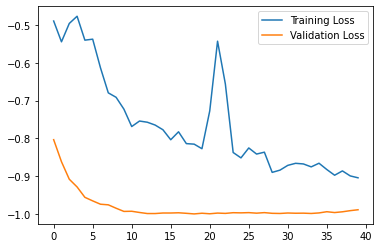

Performance on test data:
	Loss: -0.7705
	Accuracy: 81.0%


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 40
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.512533 	Validation Loss: -0.515000
Epoch: 2 	Training Loss: -0.499667 	Validation Loss: -0.488600
Epoch: 3 	Training Loss: -0.497933 	Validation Loss: -0.478200
Epoch: 4 	Training Loss: -0.525533 	Validation Loss: -0.503800
Epoch: 5 	Training Loss: -0.530200 	Validation Loss: -0.498200
Epoch: 6 	Training Loss: -0.506267 	Validation Loss: -0.698200
Epoch: 7 	Training Loss: -0.495400 	Validation Loss: -0.499600
Epoch: 8 	Training Loss: -0.572067 	Validation Loss: -0.446400
Epoch: 9 	Training Loss: -0.506400 	Validation Loss: -0.476400
Epoch: 10 	Training Loss: -0.469467 	Validation Loss: -0.586400
Epoch: 11 	Training Loss: -0.518000 	Validation Loss: -0.518400
Epoch: 12 	Training Loss: -0.470533 	Validation Loss: -0.561600
Epoch: 13 	Training Loss: -0.521867 	Validation Loss: -0.467600
Epoch: 14 	Training Loss: -0.480467 	Validation Loss: -0.505800
Epoch: 15 	Training Loss: -0.517000 	Validation Loss: -0.561800
Epoch: 16 	Training Loss: -0.463933 	Validation L

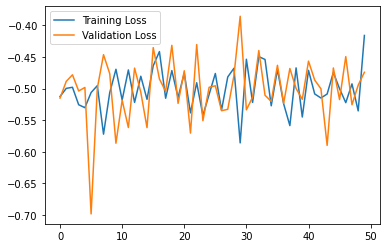

Performance on test data:
	Loss: -0.4986
	Accuracy: 47.5%


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 50
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.480067 	Validation Loss: -0.773400
Epoch: 2 	Training Loss: -0.482800 	Validation Loss: -0.809800
Epoch: 3 	Training Loss: -0.509600 	Validation Loss: -0.846200
Epoch: 4 	Training Loss: -0.521533 	Validation Loss: -0.858800
Epoch: 5 	Training Loss: -0.515667 	Validation Loss: -0.883800
Epoch: 6 	Training Loss: -0.512200 	Validation Loss: -0.887000
Epoch: 7 	Training Loss: -0.476533 	Validation Loss: -0.908200
Epoch: 8 	Training Loss: -0.513200 	Validation Loss: -0.919200
Epoch: 9 	Training Loss: -0.501467 	Validation Loss: -0.932400
Epoch: 10 	Training Loss: -0.518667 	Validation Loss: -0.928600
Epoch: 11 	Training Loss: -0.462267 	Validation Loss: -0.926800
Epoch: 12 	Training Loss: -0.530267 	Validation Loss: -0.928000
Epoch: 13 	Training Loss: -0.553400 	Validation Loss: -0.956600
Epoch: 14 	Training Loss: -0.638400 	Validation Loss: -0.969000
Epoch: 15 	Training Loss: -0.661067 	Validation Loss: -0.970400
Epoch: 16 	Training Loss: -0.680400 	Validation L

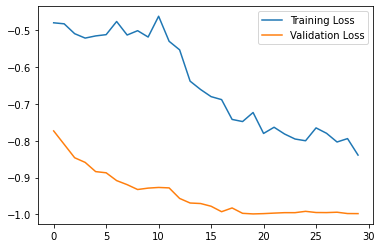

Performance on test data:
	Loss: -0.7898
	Accuracy: 83.0%


In [ ]:

###This is CPU run not GPU


%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

**Model 2 changing 500->20**

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(20, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2) #Added layer
        x = F.relu(self.conv2(x))
        x = self.dropout(x) #Added layer
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

        

Epoch: 1 	Training Loss: -0.502067 	Validation Loss: -0.480000
Epoch: 2 	Training Loss: -0.467600 	Validation Loss: -0.551200
Epoch: 3 	Training Loss: -0.490533 	Validation Loss: -0.517400
Epoch: 4 	Training Loss: -0.502400 	Validation Loss: -0.575800
Epoch: 5 	Training Loss: -0.493933 	Validation Loss: -0.500200
Validation loss decreased (inf --> -1.000000).  Saving model ...


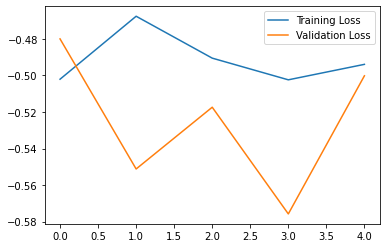

Performance on test data:
	Loss: -0.4776
	Accuracy: 44.5%


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.490667 	Validation Loss: -0.743000
Epoch: 2 	Training Loss: -0.516067 	Validation Loss: -0.773000
Epoch: 3 	Training Loss: -0.510467 	Validation Loss: -0.811200
Epoch: 4 	Training Loss: -0.523867 	Validation Loss: -0.844400
Epoch: 5 	Training Loss: -0.509867 	Validation Loss: -0.844200
Epoch: 6 	Training Loss: -0.541933 	Validation Loss: -0.901000
Epoch: 7 	Training Loss: -0.539867 	Validation Loss: -0.904400
Epoch: 8 	Training Loss: -0.599733 	Validation Loss: -0.938600
Epoch: 9 	Training Loss: -0.616600 	Validation Loss: -0.940000
Epoch: 10 	Training Loss: -0.638000 	Validation Loss: -0.944000
Epoch: 11 	Training Loss: -0.632733 	Validation Loss: -0.957800
Epoch: 12 	Training Loss: -0.692200 	Validation Loss: -0.964400
Epoch: 13 	Training Loss: -0.661333 	Validation Loss: -0.960800
Epoch: 14 	Training Loss: -0.678533 	Validation Loss: -0.971000
Epoch: 15 	Training Loss: -0.711200 	Validation Loss: -0.961600
Epoch: 16 	Training Loss: -0.702867 	Validation L

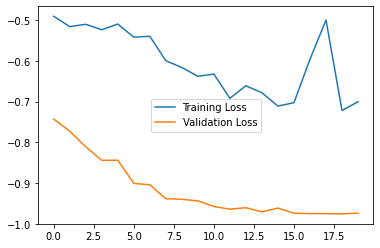

Performance on test data:
	Loss: -0.7314
	Accuracy: 73.0%


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.516000 	Validation Loss: -0.735200
Epoch: 2 	Training Loss: -0.484667 	Validation Loss: -0.799000
Epoch: 3 	Training Loss: -0.533800 	Validation Loss: -0.804000
Epoch: 4 	Training Loss: -0.538933 	Validation Loss: -0.860800
Epoch: 5 	Training Loss: -0.589600 	Validation Loss: -0.863000
Epoch: 6 	Training Loss: -0.599933 	Validation Loss: -0.889600
Epoch: 7 	Training Loss: -0.609267 	Validation Loss: -0.905200
Epoch: 8 	Training Loss: -0.623600 	Validation Loss: -0.906800
Epoch: 9 	Training Loss: -0.634800 	Validation Loss: -0.910800
Epoch: 10 	Training Loss: -0.677800 	Validation Loss: -0.912800
Epoch: 11 	Training Loss: -0.650200 	Validation Loss: -0.918600
Epoch: 12 	Training Loss: -0.656800 	Validation Loss: -0.921000
Epoch: 13 	Training Loss: -0.728667 	Validation Loss: -0.928600
Epoch: 14 	Training Loss: -0.716467 	Validation Loss: -0.933800
Epoch: 15 	Training Loss: -0.720000 	Validation Loss: -0.948400
Epoch: 16 	Training Loss: -0.723533 	Validation L

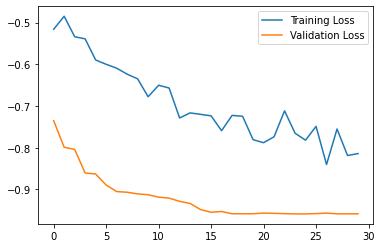

Performance on test data:
	Loss: -0.7387
	Accuracy: 73.5%


In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.483800 	Validation Loss: -0.441200
Epoch: 2 	Training Loss: -0.491800 	Validation Loss: -0.454200
Epoch: 3 	Training Loss: -0.512533 	Validation Loss: -0.475800
Epoch: 4 	Training Loss: -0.501467 	Validation Loss: -0.546000
Epoch: 5 	Training Loss: -0.505467 	Validation Loss: -0.634000
Epoch: 6 	Training Loss: -0.514867 	Validation Loss: -0.733600
Epoch: 7 	Training Loss: -0.508933 	Validation Loss: -0.753600
Epoch: 8 	Training Loss: -0.515000 	Validation Loss: -0.815800
Epoch: 9 	Training Loss: -0.514400 	Validation Loss: -0.853200
Epoch: 10 	Training Loss: -0.512000 	Validation Loss: -0.911000
Epoch: 11 	Training Loss: -0.524600 	Validation Loss: -0.915400
Epoch: 12 	Training Loss: -0.518800 	Validation Loss: -0.940000
Epoch: 13 	Training Loss: -0.523667 	Validation Loss: -0.944800
Epoch: 14 	Training Loss: -0.515533 	Validation Loss: -0.950000
Epoch: 15 	Training Loss: -0.519200 	Validation Loss: -0.955800
Epoch: 16 	Training Loss: -0.519800 	Validation L

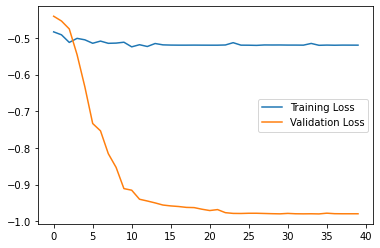

Performance on test data:
	Loss: -0.7153
	Accuracy: 73.0%


In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 40
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Model 3

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(20, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)   #Added layer
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)



        def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)   #Added layer
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Epoch: 1 	Training Loss: -0.478600 	Validation Loss: -0.456600
Epoch: 2 	Training Loss: -0.504533 	Validation Loss: -0.494000
Epoch: 3 	Training Loss: -0.506733 	Validation Loss: -0.536800
Epoch: 4 	Training Loss: -0.534333 	Validation Loss: -0.563600
Epoch: 5 	Training Loss: -0.508133 	Validation Loss: -0.573400


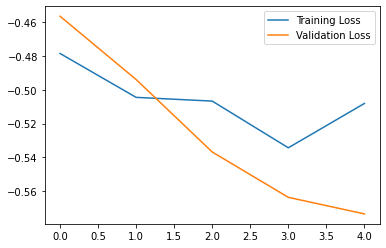

Performance on test data:
	Loss: -0.5383
	Accuracy: 51.0%


In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.505933 	Validation Loss: -0.671600
Epoch: 2 	Training Loss: -0.515200 	Validation Loss: -0.727200
Epoch: 3 	Training Loss: -0.499467 	Validation Loss: -0.788200
Epoch: 4 	Training Loss: -0.539333 	Validation Loss: -0.826400
Epoch: 5 	Training Loss: -0.547867 	Validation Loss: -0.862400
Epoch: 6 	Training Loss: -0.651800 	Validation Loss: -0.870600
Epoch: 7 	Training Loss: -0.670333 	Validation Loss: -0.886800
Epoch: 8 	Training Loss: -0.643000 	Validation Loss: -0.892400
Epoch: 9 	Training Loss: -0.671667 	Validation Loss: -0.908200
Epoch: 10 	Training Loss: -0.712467 	Validation Loss: -0.916000
Epoch: 11 	Training Loss: -0.690667 	Validation Loss: -0.934800
Epoch: 12 	Training Loss: -0.722667 	Validation Loss: -0.940800
Epoch: 13 	Training Loss: -0.736133 	Validation Loss: -0.946400
Epoch: 14 	Training Loss: -0.724333 	Validation Loss: -0.952200
Epoch: 15 	Training Loss: -0.747933 	Validation Loss: -0.954800
Epoch: 16 	Training Loss: -0.689133 	Validation L

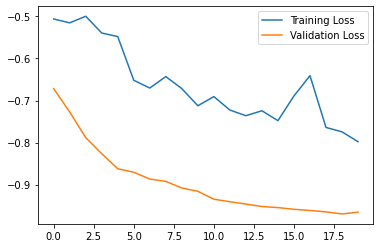

Performance on test data:
	Loss: -0.7172
	Accuracy: 72.0%


In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.506667 	Validation Loss: -0.541200
Epoch: 2 	Training Loss: -0.536333 	Validation Loss: -0.595600
Epoch: 3 	Training Loss: -0.500600 	Validation Loss: -0.491600
Epoch: 4 	Training Loss: -0.515667 	Validation Loss: -0.469600
Epoch: 5 	Training Loss: -0.504333 	Validation Loss: -0.539600
Epoch: 6 	Training Loss: -0.528533 	Validation Loss: -0.543000
Epoch: 7 	Training Loss: -0.523200 	Validation Loss: -0.563000
Epoch: 8 	Training Loss: -0.541600 	Validation Loss: -0.465000
Epoch: 9 	Training Loss: -0.575200 	Validation Loss: -0.524600
Epoch: 10 	Training Loss: -0.572733 	Validation Loss: -0.515200
Epoch: 11 	Training Loss: -0.561867 	Validation Loss: -0.594000
Epoch: 12 	Training Loss: -0.456533 	Validation Loss: -0.449000
Epoch: 13 	Training Loss: -0.485133 	Validation Loss: -0.551800
Epoch: 14 	Training Loss: -0.499867 	Validation Loss: -0.534800
Epoch: 15 	Training Loss: -0.471333 	Validation Loss: -0.594400
Epoch: 16 	Training Loss: -0.517333 	Validation L

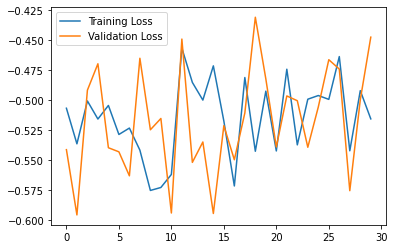

Performance on test data:
	Loss: -0.5235
	Accuracy: 53.0%


In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.502133 	Validation Loss: -0.636400
Epoch: 2 	Training Loss: -0.488933 	Validation Loss: -0.742600
Epoch: 3 	Training Loss: -0.495067 	Validation Loss: -0.766200
Epoch: 4 	Training Loss: -0.498067 	Validation Loss: -0.782600
Epoch: 5 	Training Loss: -0.484600 	Validation Loss: -0.778000
Epoch: 6 	Training Loss: -0.481067 	Validation Loss: -0.809000
Epoch: 7 	Training Loss: -0.478267 	Validation Loss: -0.809000
Epoch: 8 	Training Loss: -0.500733 	Validation Loss: -0.829200
Epoch: 9 	Training Loss: -0.499067 	Validation Loss: -0.845800
Epoch: 10 	Training Loss: -0.496067 	Validation Loss: -0.860400
Epoch: 11 	Training Loss: -0.510800 	Validation Loss: -0.864400
Epoch: 12 	Training Loss: -0.499467 	Validation Loss: -0.875600
Epoch: 13 	Training Loss: -0.524200 	Validation Loss: -0.891000
Epoch: 14 	Training Loss: -0.571267 	Validation Loss: -0.890400
Epoch: 15 	Training Loss: -0.590467 	Validation Loss: -0.900200
Epoch: 16 	Training Loss: -0.563600 	Validation L

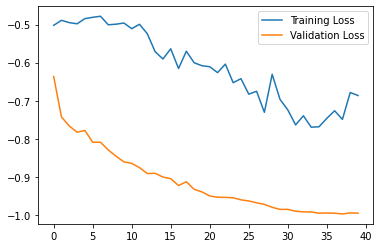

Performance on test data:
	Loss: -0.7503
	Accuracy: 76.0%


In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 40
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

**Model 4** - better accuracy rate

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d() 
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        #x = self.dropout(x) omitting this layer
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Epoch: 1 	Training Loss: -0.512333 	Validation Loss: -0.775600
Epoch: 2 	Training Loss: -0.594133 	Validation Loss: -0.830600
Epoch: 3 	Training Loss: -0.630067 	Validation Loss: -0.867600
Epoch: 4 	Training Loss: -0.711667 	Validation Loss: -0.903400
Epoch: 5 	Training Loss: -0.761467 	Validation Loss: -0.900800
Epoch: 6 	Training Loss: -0.766800 	Validation Loss: -0.938800
Epoch: 7 	Training Loss: -0.789600 	Validation Loss: -0.932400
Epoch: 8 	Training Loss: -0.799400 	Validation Loss: -0.933600
Epoch: 9 	Training Loss: -0.784267 	Validation Loss: -0.935800
Epoch: 10 	Training Loss: -0.807867 	Validation Loss: -0.927400
Epoch: 11 	Training Loss: -0.838333 	Validation Loss: -0.950600
Epoch: 12 	Training Loss: -0.849333 	Validation Loss: -0.954200
Epoch: 13 	Training Loss: -0.857267 	Validation Loss: -0.963400
Epoch: 14 	Training Loss: -0.862000 	Validation Loss: -0.951800
Epoch: 15 	Training Loss: -0.879933 	Validation Loss: -0.966200
Epoch: 16 	Training Loss: -0.886133 	Validation L

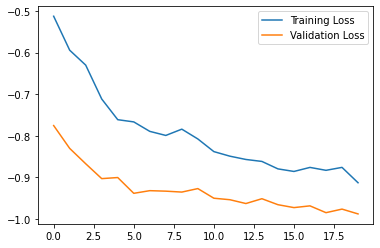

Performance on test data:
	Loss: -0.7595
	Accuracy: 80.5%


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.498400 	Validation Loss: -0.697800
Epoch: 2 	Training Loss: -0.558867 	Validation Loss: -0.674000
Epoch: 3 	Training Loss: -0.672467 	Validation Loss: -0.540800
Epoch: 4 	Training Loss: -0.738867 	Validation Loss: -0.550600
Epoch: 5 	Training Loss: -0.772000 	Validation Loss: -0.666800
Epoch: 6 	Training Loss: -0.772333 	Validation Loss: -0.503800
Epoch: 7 	Training Loss: -0.799133 	Validation Loss: -0.550800
Epoch: 8 	Training Loss: -0.817467 	Validation Loss: -0.631400
Epoch: 9 	Training Loss: -0.847867 	Validation Loss: -0.759600
Epoch: 10 	Training Loss: -0.843533 	Validation Loss: -0.790400
Epoch: 11 	Training Loss: -0.878133 	Validation Loss: -0.814600
Epoch: 12 	Training Loss: -0.881800 	Validation Loss: -0.893200
Epoch: 13 	Training Loss: -0.903400 	Validation Loss: -0.903600
Epoch: 14 	Training Loss: -0.922267 	Validation Loss: -0.947200
Epoch: 15 	Training Loss: -0.920933 	Validation Loss: -0.964200
Epoch: 16 	Training Loss: -0.936733 	Validation L

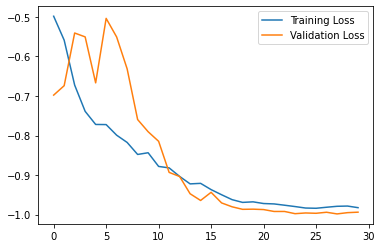

Performance on test data:
	Loss: -0.7785
	Accuracy: 83.5%


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.503200 	Validation Loss: -0.681000
Epoch: 2 	Training Loss: -0.529333 	Validation Loss: -0.506000
Epoch: 3 	Training Loss: -0.593800 	Validation Loss: -0.553200
Epoch: 4 	Training Loss: -0.739467 	Validation Loss: -0.544600
Epoch: 5 	Training Loss: -0.743267 	Validation Loss: -0.577400
Epoch: 6 	Training Loss: -0.750933 	Validation Loss: -0.599000
Epoch: 7 	Training Loss: -0.793133 	Validation Loss: -0.590600
Epoch: 8 	Training Loss: -0.809867 	Validation Loss: -0.607600
Epoch: 9 	Training Loss: -0.828200 	Validation Loss: -0.632800
Epoch: 10 	Training Loss: -0.835400 	Validation Loss: -0.636400
Epoch: 11 	Training Loss: -0.858733 	Validation Loss: -0.634000
Epoch: 12 	Training Loss: -0.859200 	Validation Loss: -0.667800
Epoch: 13 	Training Loss: -0.848467 	Validation Loss: -0.673200
Epoch: 14 	Training Loss: -0.882733 	Validation Loss: -0.655600
Epoch: 15 	Training Loss: -0.866333 	Validation Loss: -0.740600
Epoch: 16 	Training Loss: -0.888667 	Validation L

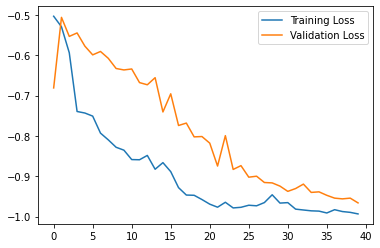

Performance on test data:
	Loss: -0.7148
	Accuracy: 76.5%


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 40
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.485333 	Validation Loss: -0.682400
Epoch: 2 	Training Loss: -0.634133 	Validation Loss: -0.820200
Epoch: 3 	Training Loss: -0.737267 	Validation Loss: -0.856600
Epoch: 4 	Training Loss: -0.780333 	Validation Loss: -0.894000
Epoch: 5 	Training Loss: -0.786400 	Validation Loss: -0.883200
Epoch: 6 	Training Loss: -0.788533 	Validation Loss: -0.925400
Epoch: 7 	Training Loss: -0.810667 	Validation Loss: -0.962200
Epoch: 8 	Training Loss: -0.791200 	Validation Loss: -0.979400
Epoch: 9 	Training Loss: -0.813000 	Validation Loss: -0.981800
Epoch: 10 	Training Loss: -0.837600 	Validation Loss: -0.997200
Epoch: 11 	Training Loss: -0.843800 	Validation Loss: -0.995400
Epoch: 12 	Training Loss: -0.884133 	Validation Loss: -0.997800
Epoch: 13 	Training Loss: -0.900400 	Validation Loss: -0.996600
Epoch: 14 	Training Loss: -0.889400 	Validation Loss: -0.994800
Epoch: 15 	Training Loss: -0.931333 	Validation Loss: -0.996200
Epoch: 16 	Training Loss: -0.943267 	Validation L

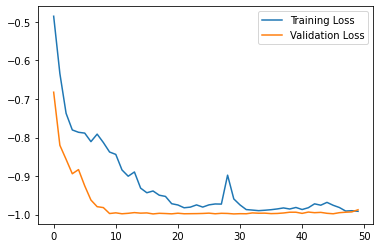

Performance on test data:
	Loss: -0.7701
	Accuracy: 82.0%


In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 50
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.541400 	Validation Loss: -0.736000
Epoch: 2 	Training Loss: -0.690600 	Validation Loss: -0.803200
Epoch: 3 	Training Loss: -0.754667 	Validation Loss: -0.867800
Epoch: 4 	Training Loss: -0.776333 	Validation Loss: -0.907200
Epoch: 5 	Training Loss: -0.784400 	Validation Loss: -0.924200
Epoch: 6 	Training Loss: -0.822000 	Validation Loss: -0.944000
Epoch: 7 	Training Loss: -0.842000 	Validation Loss: -0.961000
Epoch: 8 	Training Loss: -0.864533 	Validation Loss: -0.970000
Epoch: 9 	Training Loss: -0.881867 	Validation Loss: -0.991400
Epoch: 10 	Training Loss: -0.892867 	Validation Loss: -0.989000
Epoch: 11 	Training Loss: -0.916533 	Validation Loss: -0.990000
Epoch: 12 	Training Loss: -0.926467 	Validation Loss: -0.995400
Epoch: 13 	Training Loss: -0.942467 	Validation Loss: -0.996800
Epoch: 14 	Training Loss: -0.944200 	Validation Loss: -0.997000
Epoch: 15 	Training Loss: -0.951933 	Validation Loss: -0.996600
Epoch: 16 	Training Loss: -0.961867 	Validation L

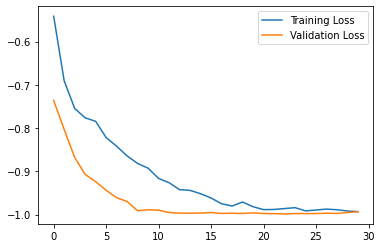

Performance on test data:
	Loss: -0.7578
	Accuracy: 80.5%


In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: 0.748926 	Validation Loss: 0.509182
Epoch: 2 	Training Loss: 0.753013 	Validation Loss: 0.435813
Epoch: 3 	Training Loss: 0.772438 	Validation Loss: 0.438703
Epoch: 4 	Training Loss: 0.730939 	Validation Loss: 0.424599
Epoch: 5 	Training Loss: 0.727822 	Validation Loss: 0.417728
Epoch: 6 	Training Loss: 0.722171 	Validation Loss: 0.413736
Epoch: 7 	Training Loss: 0.652582 	Validation Loss: 0.375665
Epoch: 8 	Training Loss: 0.647695 	Validation Loss: 0.376211
Epoch: 9 	Training Loss: 0.563613 	Validation Loss: 0.357747
Epoch: 10 	Training Loss: 0.555788 	Validation Loss: 0.361409
Epoch: 11 	Training Loss: 0.554909 	Validation Loss: 0.360107
Epoch: 12 	Training Loss: 0.516059 	Validation Loss: 0.356147
Epoch: 13 	Training Loss: 0.487939 	Validation Loss: 0.347875
Epoch: 14 	Training Loss: 0.504114 	Validation Loss: 0.343565
Epoch: 15 	Training Loss: 0.479273 	Validation Loss: 0.343249
Epoch: 16 	Training Loss: 0.489235 	Validation Loss: 0.338558
Epoch: 17 	Traini

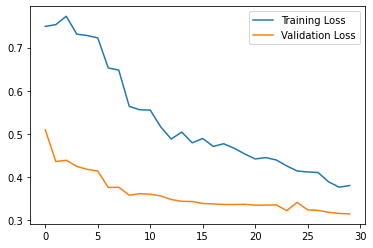

Performance on test data:
	Loss: 0.5191
	Accuracy: 78.0%


In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.CrossEntropyLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.502267 	Validation Loss: -0.754000
Epoch: 2 	Training Loss: -0.528133 	Validation Loss: -0.808600
Epoch: 3 	Training Loss: -0.659200 	Validation Loss: -0.848000
Epoch: 4 	Training Loss: -0.756733 	Validation Loss: -0.853800
Epoch: 5 	Training Loss: -0.769067 	Validation Loss: -0.885200
Epoch: 6 	Training Loss: -0.792267 	Validation Loss: -0.897400
Epoch: 7 	Training Loss: -0.790667 	Validation Loss: -0.907400
Epoch: 8 	Training Loss: -0.804733 	Validation Loss: -0.907400
Epoch: 9 	Training Loss: -0.803667 	Validation Loss: -0.929200
Epoch: 10 	Training Loss: -0.819867 	Validation Loss: -0.930600
Epoch: 11 	Training Loss: -0.820800 	Validation Loss: -0.933600
Epoch: 12 	Training Loss: -0.816200 	Validation Loss: -0.940800
Epoch: 13 	Training Loss: -0.835733 	Validation Loss: -0.948200
Epoch: 14 	Training Loss: -0.843867 	Validation Loss: -0.953600
Epoch: 15 	Training Loss: -0.842133 	Validation Loss: -0.956000
Epoch: 16 	Training Loss: -0.845333 	Validation L

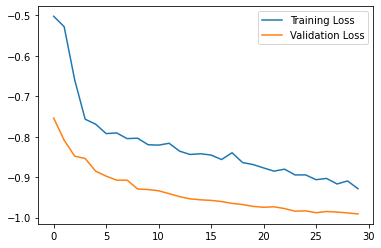

Performance on test data:
	Loss: -0.7630
	Accuracy: 79.5%


In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )